# Test GEModelTools - HANK

This notebook shows how to **solve a simple Heterogenous Agent New Keynessian (HANK) model** using the `GEModelTools` package.

**The steps of the sequence-space solution method are:**

1. Find the stationary equilibrium (steady state for aggregates and distribution).
2. Compute Jacobians of the household block and the full model (to unknowns and shocks)
3. Find the non-linear transition path or the linearized impulse responses to a given shock path.
4. Simulate the linearized model with aggregate risk

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
import sys
from scipy import optimize

import matplotlib.pyplot as plt   
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
#np.set_printoptions(threshold=sys.maxsize)

from HANKmodel import HANKModelClass

C:\Users\Signe\AppData\Local\Temp\ipykernel_21836\1518818971.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


# Setup

In [8]:
#print(model)
model = HANKModelClass(name='baseline')

# Step 1: Steady state

In [9]:
model.find_ss(do_print=True)

Z_N = 0.5768,	 Z_L = 0.5000,	 Q = 1.0000,	 M_N = 0.2273,	 M_L = 0.1136,	 beta = 0.9875,	 N_N = 0.4816,	 N_L = 0.7759
Z_N = 0.5768,	 Z_L = 0.5000,	 Q = 1.0000,	 M_N = 0.2273,	 M_L = 0.1136,	 beta = 0.9875,	 N_N = 0.4816,	 N_L = 0.7759
Z_N = 0.5768,	 Z_L = 0.5000,	 Q = 1.0000,	 M_N = 0.2273,	 M_L = 0.1136,	 beta = 0.9875,	 N_N = 0.4816,	 N_L = 0.7759
Z_N = 0.5768,	 Z_L = 0.5000,	 Q = 1.0000,	 M_N = 0.2273,	 M_L = 0.1136,	 beta = 0.9875,	 N_N = 0.4816,	 N_L = 0.7759
Z_N = 0.5768,	 Z_L = 0.5000,	 Q = 1.0000,	 M_N = 0.2273,	 M_L = 0.1136,	 beta = 0.9875,	 N_N = 0.4816,	 N_L = 0.7759
Z_N = 0.5768,	 Z_L = 0.5000,	 Q = 1.0000,	 M_N = 0.2273,	 M_L = 0.1136,	 beta = 0.9875,	 N_N = 0.4816,	 N_L = 0.7759
Z_N = 1.6897,	 Z_L = 0.3803,	 Q = 1.6467,	 M_N = 0.2171,	 M_L = 0.1136,	 beta = 0.9929,	 N_N = 0.3081,	 N_L = 1.0202
Z_N = 1.5530,	 Z_L = 0.4367,	 Q = 1.5382,	 M_N = 0.2198,	 M_L = 0.1136,	 beta = 0.9909,	 N_N = 0.3037,	 N_L = 0.8884
Z_N = 1.4257,	 Z_L = 0.4492,	 Q = 1.4824,	 M_N = 0.2211,	 M_L = 

In [10]:
model.solve_hh_ss(do_print=True)

household problem in ss solved in 5.9 secs [782 iterations]


In [11]:
par = model.par
ss = model.ss
path = model.path
sim = model.sim

In [11]:
print("steady state consumption C_hh", ss.C_hh,"C_Lhh", ss.C_L_hh,"C_Nhh", ss.C_N_hh)
print("steady state consumption C", ss.C,"C_L", ss.C_L,"C_N", ss.C_N)
print("steaty state production Y", ss.Y,"Y_L", ss.Y_L,"Y_N", ss.Y_N)
print(ss.Q*ss.Y_L + ss.Y_N) 
#print(ss.C_L*ss.Q + ss.C_N + (ss.M_L+ss.M_N)*ss.pm)

steady state consumption C_hh 0.5895980183872833 C_Lhh 0.374999999403021 C_Nhh 0.2303052772858793
steady state consumption C 0.5895980190535947 C_L 0.375 C_N 0.23030527728586725
steaty state production Y 1.0 Y_L 0.5 Y_N 0.5950479875544715
1.3464965463995828


In [12]:
print("Steady state W_L, W_N, Q = ", ss.w_L, ss.w_N, ss.Q)
print("Steady state B, G, A, A_HH, tau = ", ss.B, ss.G, ss.A, ss.A_hh, ss.tau)
#print("Steady state interest rate", ss.r)
print("steady state consumption C_hh", ss.C_hh,"C_Lhh", ss.C_L_hh,"C_Nhh", ss.C_N_hh)
print("Steady state laborsupply ell ", ss.c)
print("varphi= ", par.varphi, "beta = ", par.beta)
print(ss.N_N, ss.Y_N, ss.N_L, ss.Y_L)

Steady state W_L, W_N, Q =  0.37257511655523745 0.5599420687939651 1.5028971176902226
Steady state B, G, A, A_HH, tau =  5.6 0.0 5.6 5.600000000000058 0.0
steady state consumption C_hh 0.5895980183872833 C_Lhh 0.374999999403021 C_Nhh 0.2303052772858793
Steady state laborsupply ell  [[[0.21124559 0.21285118 0.21448777 ... 1.22811171 1.23536243 1.24267649]
  [0.28875017 0.29036382 0.29200548 ... 1.24583788 1.25298184 1.26018973]
  [0.39495901 0.39651691 0.39732    ... 1.26727569 1.27429375 1.2813764 ]
  ...
  [0.62330658 0.62335776 0.62340955 ... 1.327081   1.33377049 1.34052583]
  [0.73136502 0.73139771 0.73143078 ... 1.36991832 1.37639408 1.38293614]
  [0.84501934 0.84504353 0.845068   ... 1.42587855 1.43210196 1.43839184]]]
varphi=  0.8 beta =  0.991200899884904
0.3146932790199837 0.5950479875544715 0.8845074185103194 0.5


In [13]:
#ss.c
print(ss.c_N[0,1,:])
#ss.c_L.shape
#ss.C_L_hh
#ss.C_hh

[0.11278988 0.11342019 0.11406145 0.11471367 0.11504529 0.11538084
 0.11571966 0.11606288 0.11641147 0.11672614 0.11696994 0.11721272
 0.11745794 0.11770592 0.11795666 0.11821104 0.11846056 0.11869749
 0.11890189 0.11910611 0.11931094 0.11951751 0.11972645 0.11993781
 0.12015197 0.12036422 0.12057144 0.12076493 0.12095056 0.12113677
 0.12132388 0.12151211 0.12170216 0.12189443 0.12208916 0.12228357
 0.12247579 0.12266119 0.12284047 0.12301819 0.12319686 0.1233766
 0.12355754 0.12373995 0.12392432 0.1241105  0.12429672 0.1244813
 0.12466136 0.12483756 0.12501309 0.12518972 0.12536755 0.12554662
 0.12572707 0.12590908 0.12609275 0.12627688 0.12646018 0.12664036
 0.12681776 0.12699481 0.12717302 0.1273525  0.12753331 0.12771553
 0.12789923 0.12808438 0.12827014 0.12845557 0.12863874 0.12881982
 0.12900092 0.12918332 0.12936711 0.12955233 0.12973902 0.12992722
 0.13011675 0.13030676 0.13049636 0.13068428 0.13087102 0.13105831
 0.13124704 0.13143729 0.13162908 0.13182243 0.13201729 0.132213

## Policy functions

In [150]:
#fig = plt.figure(figsize=(18,4),dpi=100)
#a_max = 500
#
## a. consumption
#I = par.a_grid < a_max
#
#ax = fig.add_subplot(1,3,1)
#ax.set_title(f'consumption')
#
#for i_z in [0,par.Nz//2,par.Nz-1]:
#    ax.plot(par.a_grid[I],ss.c[0,i_z,I],label=f'i_z = {i_z}')
#
#ax.legend(frameon=True)
#ax.set_xlabel('savings, $a_{t-1}$')
#ax.set_ylabel('consumption, $c_t$')
#
## b. saving
#I = par.a_grid < a_max
#
#ax = fig.add_subplot(1,3,2)
#ax.set_title(f'saving')
#
#for i_z in [0,par.Nz//2,par.Nz-1]:
#    ax.plot(par.a_grid[I],ss.a[0,i_z,I],label=f'i_z = {i_z}')
#
#ax.set_xlabel('savings, $a_{t-1}$')
#ax.set_ylabel('savings, $a_{t}$')
#
## c. labor supply
#I = par.a_grid < a_max
#
#ax = fig.add_subplot(1,3,3)
#ax.set_title(f'labor_supply')
#
#for i_z in [0,par.Nz//2,par.Nz-1]:
#    ax.plot(par.a_grid[I],ss.ell[0,i_z,I],label=f'i_z = {i_z}')
#
#ax.set_xlabel('savings, $a_{t-1}$')
#ax.set_ylabel('labor supply, $n_{t}$')
#
#fig.tight_layout()

## Simulation

In [151]:
#fig = plt.figure(figsize=(12,4),dpi=100)
#
## a. income
#ax = fig.add_subplot(1,2,1)
#ax.set_title('productivity')
#
#y = np.cumsum(np.sum(ss.D[0],axis=1))
#ax.plot(par.z_grid,y/y[-1])
#
#ax.set_xlabel('productivity, $z_{t}$')
#ax.set_ylabel('CDF')
#
## b. assets
#ax = fig.add_subplot(1,2,2)
#ax.set_title('savings')
#y = np.insert(np.cumsum(np.sum(ss.D[0],axis=0)),0,0.0)
#ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),y/y[-1])
#        
#ax.set_xlabel('assets, $a_{t}$')
#ax.set_ylabel('CDF')
#ax.set_xscale('symlog')


# Step 2: Compute Jacobians (incl. tests)

**Household transition path:**

note: inputs = steady state value -> expected: constant value (straigt line)

household problem solved along transition path in 1.5 secs
household problem simulated along transition in 0.3 secs



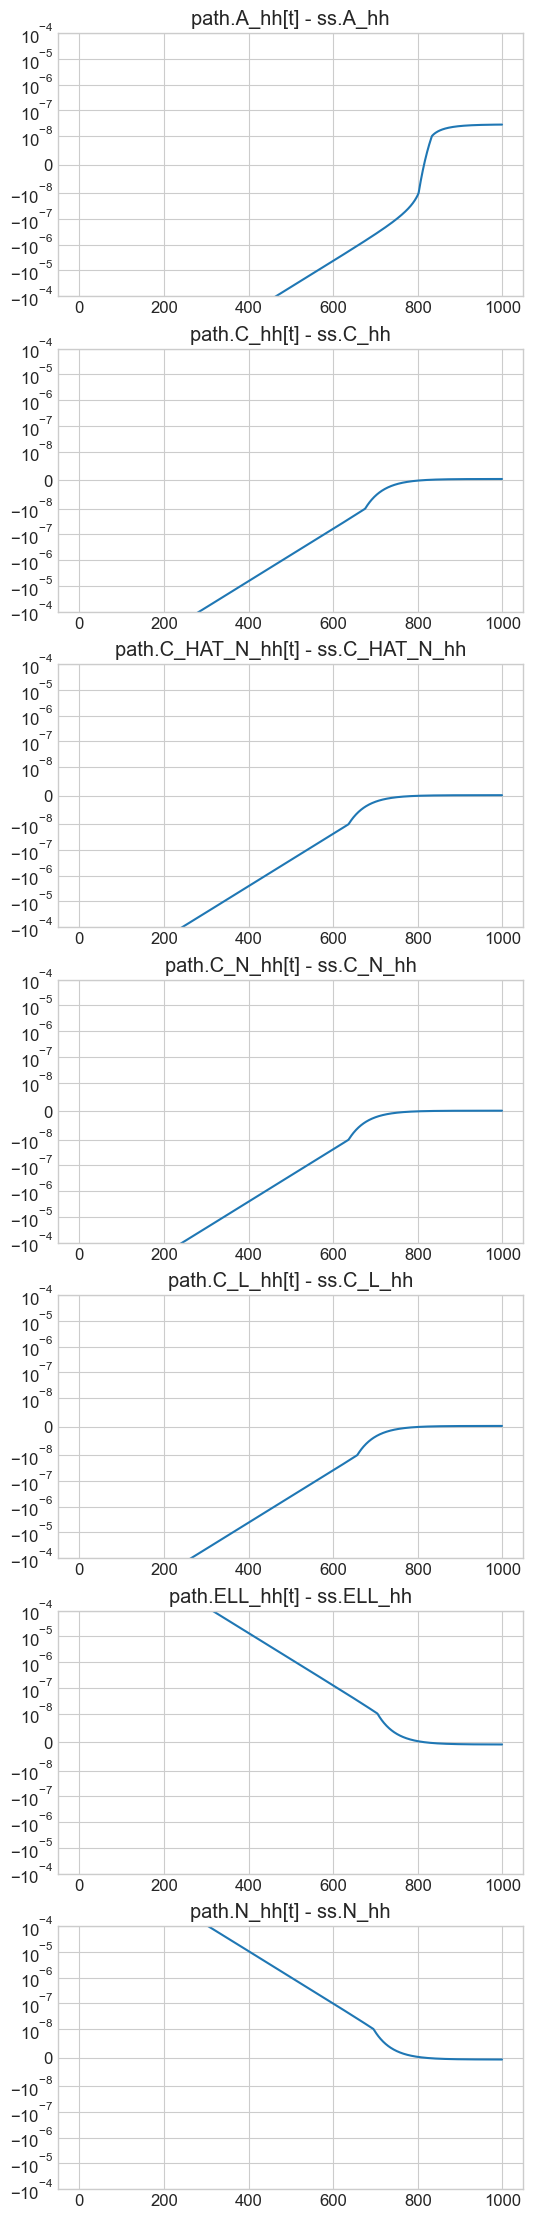

In [12]:
model.test_hh_path()

**Full transition path:**

In [13]:
model.test_path()

note: inputs = steady state value -> expected: no difference to steady state and zero errors

difference to value at steady state:
A              : t0 =  0.0e+00, max abs.  0.0e+00
B              : t0 =  0.0e+00, max abs.  0.0e+00
C              : t0 = -3.6e-01, max abs.  3.6e-01
C_N            : t0 = -7.2e-02, max abs.  7.2e-02
C_L            : t0 = -2.7e-01, max abs.  2.7e-01
d_N            : t0 = -3.9e-01, max abs.  3.9e-01
d_L            : t0 = -2.7e-01, max abs.  2.7e-01
G              : t0 =  0.0e+00, max abs.  0.0e+00
i              : t0 =  5.0e-03, max abs.  5.0e-03
N              : t0 =  5.7e-01, max abs.  5.7e-01
N_N            : t0 = -3.1e-01, max abs.  3.1e-01
N_L            : t0 = -8.8e-01, max abs.  8.8e-01
M_N            : t0 =  0.0e+00, max abs.  0.0e+00
M_L            : t0 =  0.0e+00, max abs.  0.0e+00
pm_L           : t0 =  0.0e+00, max abs.  0.0e+00
pm_N           : t0 =  0.0e+00, max abs.  0.0e+00
pi_N           : t0 =  0.0e+00, max abs.  0.0e+00
pi_L           : t0

In [ ]:
model.test_jacs(s_list=[50,100,150])

# Step 3a: Find non-linear transition path

## Find transition path

In [ ]:
par.jump_pm = 0.10/4
model.find_transition_path(do_print=True)

## Plot transitions

In [ ]:
paths = ['i','pi_L','pi_N','r','C_N']
lvl_value = ['i','pi_L','pi_N','r']
model.show_IRFs(paths,lvl_value=lvl_value,T_max=20,ncols=3)

# Step 3b: Find linearized IRFs

In [ ]:
model.find_IRFs(do_print=True)

In [ ]:
paths = ['C']
model.show_IRFs(paths,T_max=20,ncols=3,do_linear=True)

# Step 4. Simulation

In [ ]:
np.random.seed(1917)
model.simulate(do_print=True)

In [ ]:
def model_sim():
    
    fig = plt.figure(figsize=(12,8),dpi=100)

    ax = fig.add_subplot(2,2,1)
    ax.set_title('i')
    ax.plot(ss.i+sim.di,ls='--')
    ax.axhline(ss.i,color='black',zorder=0)

    ax = fig.add_subplot(2,2,2)
    ax.set_title('pi')
    ax.plot(ss.pi+sim.dpi,ls='--',)
    ax.axhline(ss.pi,color='black',zorder=0)
    
    ax = fig.add_subplot(2,2,3)
    ax.set_title('r')
    ax.plot(ss.r+sim.dr,ls='--',)
    ax.axhline(ss.r,color='black',zorder=0)
    
    ax = fig.add_subplot(2,2,4)
    ax.set_title('C')
    ax.plot(ss.C+sim.dC,ls='--',)
    ax.axhline(ss.C,color='black',zorder=0)
    

In [ ]:
model_sim()